In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine', 'inverse_l1'],
                        text_compositions=['average', 'idf', 'bi_lstm'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[24],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True,
                        embedding_trainable=True,
                        lstm_args=dict(units=25),
                        dropout=0.75,
                        batch_norm=True)

Number of inputs to dense layer: 110


# Train model 

In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=2048,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 420s 973us/step - loss: 0.0020 - acc: 0.9997 - val_loss: 0.0052 - val_acc: 0.9995


# Learning curves

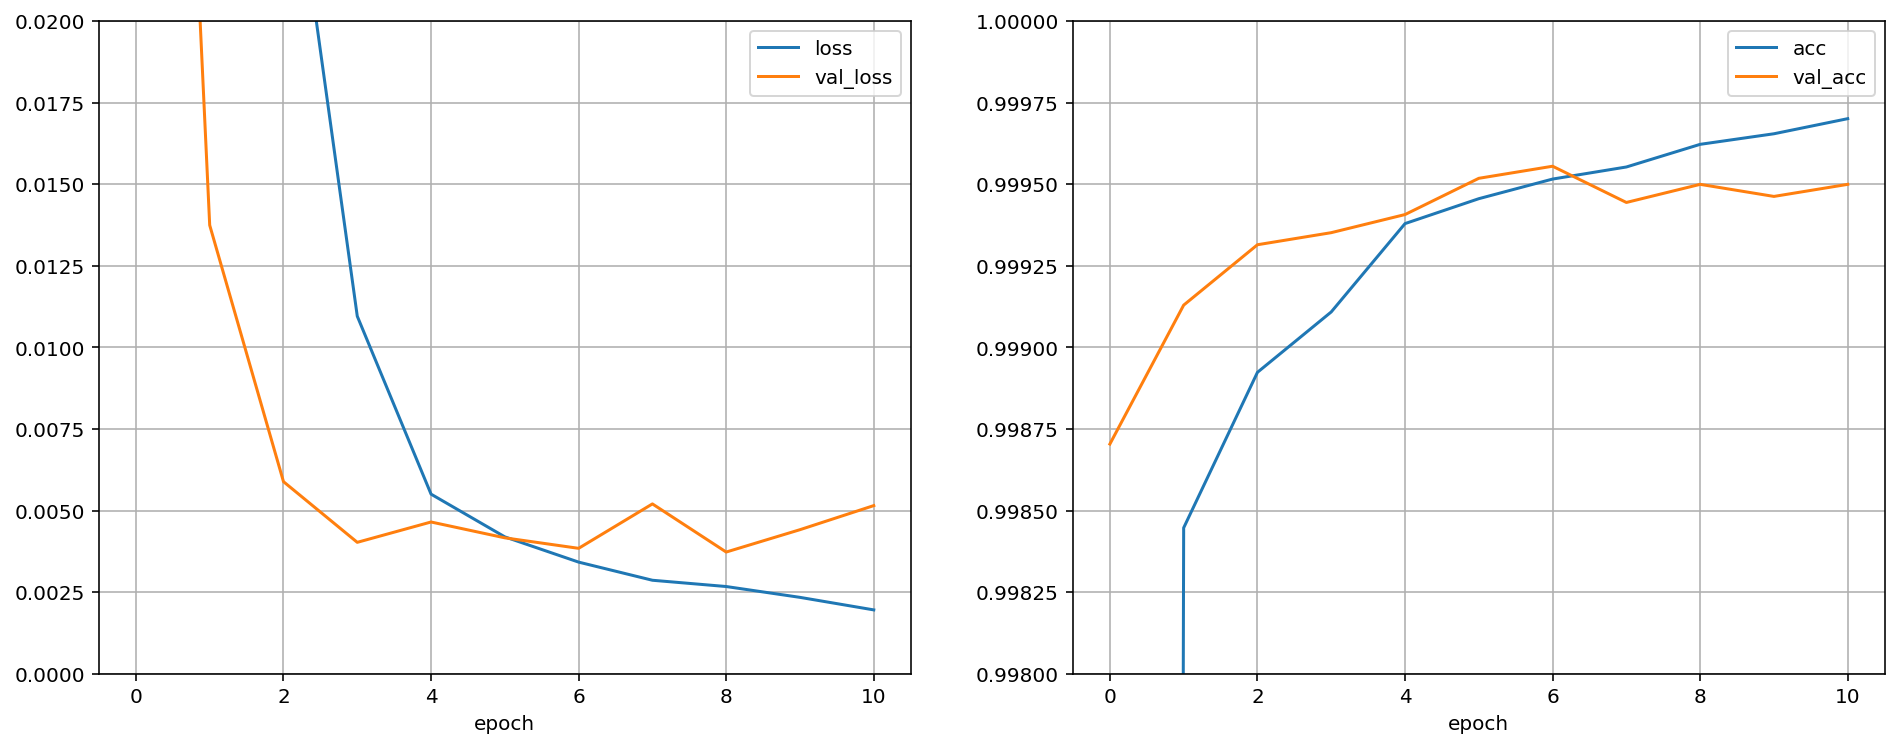

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(0.998, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [42]:
y_val_pred = model.predict(X_val, batch_size=4096)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53429
          1       0.98      0.97      0.98       575

avg / total       1.00      1.00      1.00     54004

[[53418    11]
 [   16   559]]


In [43]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(3)

,id1,title,authors,venue,year,id2,title,authors,venue,year
7389,conf/sigmod/FranklinJK96,Performance Tradeoffs for Client-Server Query Processing,"M Franklin , B Jónsson , D Kossmann",SIGMOD Conference,1996,0e3bs1VFPvAJ,Performance TRADEOFFSFORCLIENT-SERVERQUERYPROCESSING,"MJ Franklin , DK BJORNTHORJONSSON",Proceedings of the ACM SIGMOD International Conference on,0.0
17891,journals/sigmod/MillerHHYHFP01,The Clio Project : Managing Heterogeneity,"R Miller , M Hernández , L Haas , L Yan , C Ho , R Fagin , L Popa",SIGMOD Record,2001,q_MyUzye5SoJ,The clio project : Managing HETEROGENEITY. 30 ( 1 ) : 78Ã¢ ? ? 83,"RJ Miller , MA Hernandez , LM Haas , L Yan , CTH Ho , R",NaN,2001.0
15453,conf/sigmod/ChangG99,Mind Your Vocabulary : Query Mapping Across Heterogeneous Information Sources,"K Chang , H Garcia-Molina",SIGMOD Conference,1999,10FYofnRROUJ,QUERY AND DATA MAPPING ACROSS HETEROGENEOUS INFORMATION SOURCES,KCC Chang,NaN,2001.0


# Save model and histories 

In [44]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-all-full.csv', index=False)
model.save_weights('../data/models/dblp-scholar-all-full')

# Test model 

In [45]:
y_test_pred = model.predict(X_test, batch_size=4096)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99978   0.99987   0.99982     53502
          1    0.98594   0.97614   0.98102       503

avg / total    0.99965   0.99965   0.99965     54005

[[53495     7]
 [   12   491]]
